In [1]:
# Import required Julia packages for oceanographic data analysis
using NCDatasets, PhysOcean, DataStructures    # NetCDF I/O, oceanography utilities, data structures
using DIVAnd, PyPlot, Dates                     # DIVA interpolation, plotting, date handling
using Statistics, Random, Printf                # Statistical functions, random numbers, string formatting

#load dataset
datafile = "./nc/chlorophyll-a.nc"

"./nc/chlorophyll-a.nc"

In [2]:
# Define spatial grid parameters for the Mediterranean Sea analysis
# CORRECTED: Optimized grid resolution for chlorophyll-a analysis
# Finer resolution needed for chlorophyll-a spatial variability but balanced with computation time
dx, dy = 0.1, 0.1    # Grid resolution in degrees (longitude, latitude) - higher resolution (~2.8 km)
# Alternative options:
# dx, dy = 0.02, 0.02      # Ultra-high resolution (~2.2 km) - computationally intensive
# dx, dy = 0.01, 0.01      # Maximum resolution (~1.1 km) - very computationally intensive
lonr = -6:dx:37            # Longitude range from -6° to 37° E covering entire Mediterranean
latr = 30:dy:46            # Latitude range from 30° to 46° N covering entire Mediterranean
timerange = [Date(2003,06,06),Date(2012,01,01)];  # Time period for analysis

In [3]:
# Define depth levels for chlorophyll-a 3D analysis (in meters)
depthr = [0., 5., 10., 20., 30., 40., 50., 75., 100., 125., 150., 200.];  # 12 key depths

# Define analysis parameters
varname = "Water_body_chlorophyll_a"    # CORRECTED: Using correct variable name for chlorophyll-a
yearlist = [2003:2012]; # Years to include in analysis

# CORRECTED: Seasonal groupings following EMODnet Chemistry guidelines (Page 35)
# Mediterranean seasons: winter (Jan-Mar), spring (Apr-Jun), summer (Jul-Sep), autumn (Oct-Dec)
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]]; # Winter, Spring, Summer, Autumn - EMODnet standard

# Create time selector for seasonal analysis
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

TS = TimeSelectorYearListMonthList{Vector{UnitRange{Int64}}, Vector{Vector{Int64}}}(UnitRange{Int64}[2003:2012], [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])


2610 out of 72191 - 3.6154091230208754 %
5360 out of 72191 - 7.424748237314901 %
8050 out of 72191 - 11.150974498206148 %
10710 out of 72191 - 14.835644332396004 %
13580 out of 72191 - 18.81120915349559 %
16380 out of 72191 - 22.689808978958595 %
19240 out of 72191 - 26.651521657824382 %
22110 out of 72191 - 30.627086478923964 %
24990 out of 72191 - 34.61650344225735 %
27860 out of 72191 - 38.59206826335693 %
30730 out of 72191 - 42.56763308445651 %
33600 out of 72191 - 46.54319790555609 %
36480 out of 72191 - 50.532614868889475 %
39390 out of 72191 - 54.56358825892424 %
42300 out of 72191 - 58.59456164895901 %
45200 out of 72191 - 62.61168289675999 %
48110 out of 72191 - 66.64265628679475 %
51020 out of 72191 - 70.67362967682952 %
53920 out of 72191 - 74.69075092463049 %
56810 out of 72191 - 78.69402003019766 %
59690 out of 72191 - 82.68343699353105 %
62580 out of 72191 - 86.68670609909823 %
65450 out of 72191 - 90.66227092019781 %
68350 out of 72191 - 94.67939216799878 %
71230 out of

[ Info: Checking ranges for dimensions and observations


DateTime("2003-01-07T12:07:21"), DateTime("2012-12-26T08:53:38"))
                          minimum and maximum of data: (0.009999999776482582, 147.0)


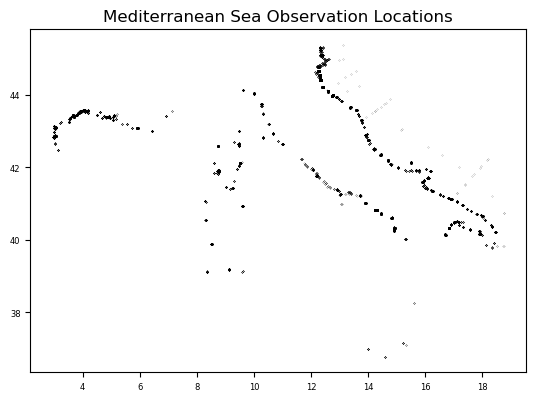

In [4]:
# Then load from full dataset 
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body chlorophyll-a");

# ========================================================================
# PLOTTING OBSERVATIONAL DATA DISTRIBUTION
# ========================================================================

# Create a figure showing the geographic distribution of observation points
figure("Mediterranean-Data")
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1)  # Plot observation locations as small black dots
aspectratio = 1/cos(mean(latr) * pi/180)   # Calculate proper aspect ratio for latitude
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)
title("Mediterranean Sea Observation Locations")

# Check quality and consistency of observations
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

  2.182543 seconds (3.92 M allocations: 276.020 MiB, 7.14% gc time, 97.27% compilation time)
size(mask) = (431, 161, 12)
size(mask_edit) = (431, 161, 12)
size(mask_edit) = (431, 161, 12)


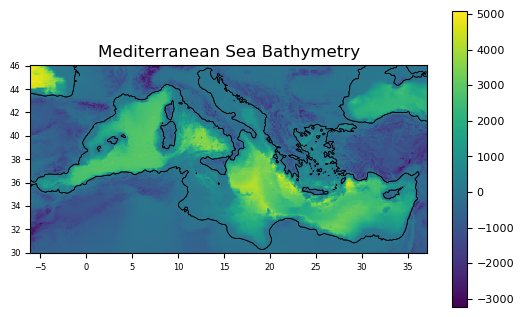

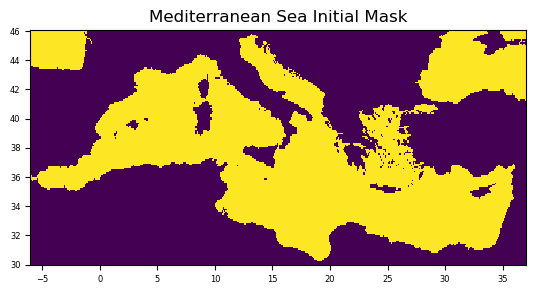

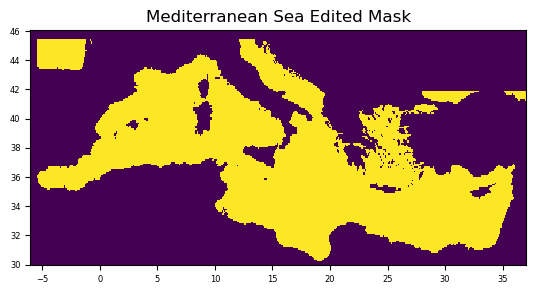

(431, 161, 12)

In [5]:
# Download bathymetry data (seafloor depth) for the Mediterranean Sea region
bathname = "./nc/gebco_30sec_4.nc"

# Load bathymetry data and interpolate to our Mediterranean grid
@time bx,by,b = load_bath(bathname,true,lonr,latr);

# Plot the bathymetry data for the Mediterranean Sea
figure("Mediterranean-Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));  
colorbar(orientation="vertical", shrink=0.8, label="Depth (m)").ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0], colors="k", linewidths=1.0)  # Coastline
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
title("Mediterranean Sea Bathymetry")

# Create simple 3D mask - just water vs land based on bathymetry
mask = falses(size(b,1), size(b,2), length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]  # True where water depth >= analysis depth
        end
    end
end

# Plot the mask (surface level)
figure("Mediterranean-Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
pcolor(bx,by, transpose(mask[:,:,1])); 
title("Mediterranean Sea Water Mask")

In [6]:
# DIVAND ANALYSIS PARAMETERS SETUP (EMODnet Chemistry Standards) - Following EMODnet Chemistry DIVA Guidelines (Page 37-38)

# Optional: Calculate observation weights based on data density
# Recommended for high-density datasets to account for spatial clustering
@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.05,0.05));
@show maximum(rdiag),mean(rdiag)

# Define grid dimensions for parameter arrays
sz = (length(lonr),length(latr),length(depthr));

# Set correlation lengths (influence radius) for each dimension
# Based on EMODnet recommendation: "Minimal L (larger than output grid spacing): 0.25, Maximal L: 10"
# Grid resolution is 0.1° ≈ 11 km, so minimum correlation length should be ~22 km

# For chlorophyll-a in Mediterranean (high spatial variability parameter):
lenx = fill(50_000.,sz)    # 50 km correlation length in longitude direction (chlorophyll patchiness)
leny = fill(50_000.,sz)    # 50 km correlation length in latitude direction (chlorophyll patchiness)
lenz = fill(20.,sz);       # 20 m correlation length in depth direction (chlorophyll vertical structure)
len = (lenx, leny, lenz);  # Combine into tuple for DIVAnd

# Set noise-to-signal ratio (regularization parameter)
# CORRECTED: Following EMODnet guidelines "Minimal SN: 0.1, Maximal SN: 3"
# Lower epsilon2 for chlorophyll-a due to high natural variability
epsilon2 = 0.02;           # Within EMODnet recommended range for high variability parameters
epsilon2 = epsilon2 * rdiag;  # Apply spatially varying epsilon based on data density

[ Info: Computing weights using 1 CPU thread(s)


  1.450195 seconds (2.42 M allocations: 149.983 MiB, 5.29% gc time, 96.28% compilation time)
(maximum(rdiag), mean(rdiag)) = (708.8259471473774, 272.2219369346332)


In [7]:
# ========================================================================
# OUTPUT FILE SETUP AND METADATA CONFIGURATION
# ========================================================================

# Set up output directory and filename
outputdir = "./"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Mediterranean.4Danl.nc")

# Define comprehensive metadata for NetCDF file following SeaDataNet standards
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset. EMODnet Chemistry QC procedures applied.",

    # SeaDataNet Vocabulary P35 URN for chlorophyll-a
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    "parameter_keyword_urn" => "SDN:P35::EPC00001", # Chlorophyll-a concentration

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs for chlorophyll-a
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    "search_keywords_urn" => ["SDN:P02::CPWC"], # Chlorophyll pigment concentrations

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    "area_keywords_urn" => ["SDN:C19::3_1"], # Mediterranean Sea

    "product_version" => "1.0",
    
    "product_code" => "Mediterranean-Chlorophyll-a-Analysis",
    
    # bathymetry source acknowledgement
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name for chlorophyll-a
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    "netcdf_standard_name" => "mass_concentration_of_chlorophyll_a_in_sea_water",

    "netcdf_long_name" => "Mass concentration of chlorophyll-a in sea water",

    "netcdf_units" => "mg m-3",

    # Abstract for the product
    "abstract" => "4D analysis of chlorophyll-a concentration in Mediterranean Sea using DIVAnd interpolation following EMODnet Chemistry methodology",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "EMODnet Chemistry project, SeaDataNet infrastructure",

    "documentation" => "https://doi.org/10.6092/9f75ad8a-ca32-4a72-bf69-167119b2cc12",

    # Digital Object Identifier of the data product
    "doi" => "...");

# Convert metadata to NetCDF-compatible attributes
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

# Remove any existing analysis file to start fresh
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

In [8]:
# Metadata configuration

# Set up output directory and filename
outputdir = "../"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Mediterranean.4Danl.nc")

# Define comprehensive metadata for NetCDF file following SeaDataNet standards
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset. EMODnet Chemistry QC procedures applied.",

    # SeaDataNet Vocabulary P35 URN for chlorophyll-a
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    "parameter_keyword_urn" => "SDN:P35::EPC00001", # Chlorophyll-a concentration

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs for chlorophyll-a
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    "search_keywords_urn" => ["SDN:P02::CPWC"], # Chlorophyll pigment concentrations

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    "area_keywords_urn" => ["SDN:C19::3_1"], # Mediterranean Sea

    "product_version" => "1.0",
    
    "product_code" => "Mediterranean-Chlorophyll-a-Analysis",
    
    # bathymetry source acknowledgement
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name for chlorophyll-a
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    "netcdf_standard_name" => "mass_concentration_of_chlorophyll_a_in_sea_water",

    "netcdf_long_name" => "Mass concentration of chlorophyll-a in sea water",

    "netcdf_units" => "mg m-3",

    # Abstract for the product
    "abstract" => "4D analysis of chlorophyll-a concentration in Mediterranean Sea using DIVAnd interpolation following EMODnet Chemistry methodology",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "EMODnet Chemistry project, SeaDataNet infrastructure",

    "documentation" => "https://doi.org/10.6092/9f75ad8a-ca32-4a72-bf69-167119b2cc12",

    # Digital Object Identifier of the data product
    "doi" => "...");

# Convert metadata to NetCDF-compatible attributes
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

# Remove any existing analysis file to start fresh
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

[ Info: Removing file ../Water_body_Water_body_chlorophyll_a_Mediterranean.4Danl.nc


In [9]:
# Main DIVAND execution

# Execute the main DIVAnd 3D analysis
@time dbinfo = diva3d((lonr,latr,depthr,TS),        # Grid coordinates and time selector
    (obslon,obslat,obsdepth,obstime), obsval,        # Observation coordinates and values
    len, epsilon2,                                    # Correlation lengths and regularization
    filename,varname,                                 # Output file and variable name
    bathname=bathname,                               # Bathymetry file for land/sea mask
    #plotres = plotres,                               # CORRECTED: Enable plotting function for visualization
    mask = mask,                                     # Simple mask for analysis domain (water areas only)
    fitcorrlen = false,                              # Don't fit correlation lengths automatically
    niter_e = 1,                                     # CORRECTED: Reduce iterations for faster computation
    ncvarattrib = ncvarattrib,                       # NetCDF variable attributes
    ncglobalattrib = ncglobalattrib,                 # NetCDF global attributes
    surfextend = true,                               # Extend surface values to deeper levels if needed
    memtofit = 3,                                    # CORRECTED: Optimize memory usage for large grids
    );

# Save observation metadata to the output file
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);

[ Info: Creating netCDF file ../Water_body_Water_body_chlorophyll_a_Mediterranean.4Danl.nc
[ Info: Time step 1 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (50000.0, 50000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (50000.0, 50000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (20.0, 20.0)
┌ Warning: resolution (17.5) is too coarse for correlation length 20.0 in dimension 3 at indices CartesianIndex(250, 6, 8) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd /opt/julia/packages/DIVAnd/4UymR/src/utils.jl:18
[ Info: number of windows: 15
[ Info: Time step 2 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (50000.0, 50000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (50000.0, 50000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (20.0, 20.0)
┌ Warning: resolution (17.5) is too coarse for correlation length 2

402.399059 seconds (82.41 M allocations: 300.105 GiB, 6.68% gc time, 14.91% compilation time)
